In [76]:
###Import standard packages###
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder

In [350]:
###Load Data###
folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/' 
data=io.loadmat(folder+'jeb7_decoding.mat')
# spike_times=data['spike_times'] #Load spike times of all neurons
# vels=data['vels'] #Load x and y velocities
# vel_times=data['vel_times'] #Load times at which velocities were recorded

In [351]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'gauss', 'lfads', 'ylow', 'yup'])

In [374]:
lfads = data['lfads']
gauss = data['gauss']
ylow = data['ylow']
yup = data['yup']

In [390]:
X_kf = lfads
X_kf.shape

(196000, 10)

In [391]:
lag=-5 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

y_kf = np.concatenate([yup],axis=1)
 
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]
    
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]


#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]


/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_3127/185316405.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_3127/185316405.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish t

In [392]:
print(y_kf.shape)
print(X_kf.shape)

(195995, 1)
(195995, 10)


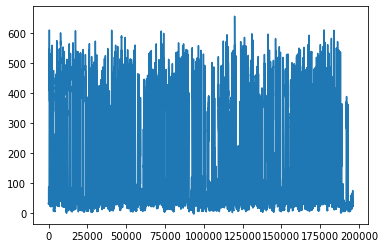

In [393]:
plt.plot(y_kf)

In [394]:
#Z-score inputs 
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

X_kf_full = X_kf
X_kf_full_mean=np.nanmean(X_kf_full,axis=0)
X_kf_full_std=np.nanstd(X_kf_full,axis=0)
X_kf_full=(X_kf_full-X_kf_full_mean)/X_kf_full_std

#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

y_kf_full = y_kf
y_kf_full_mean = np.mean(y_kf_full,axis=0)
y_kf_full = y_kf_full - y_kf_full_mean


In [395]:


#Declare model
model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities



R2: [0.40070338]
rho2: [0.49676923]


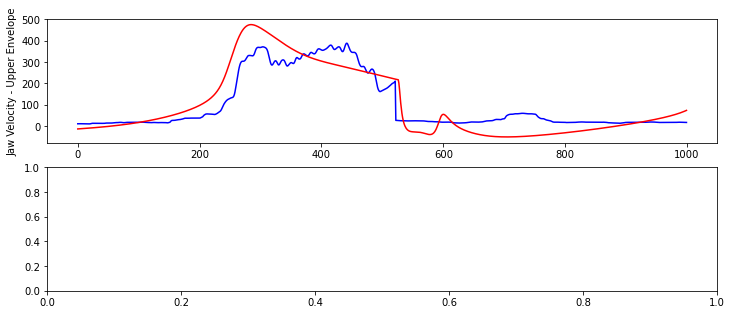

In [402]:
nIdx = y_kf_valid.shape[0]
nIdx = nIdx - 1001
low = np.random.randint(0, high=nIdx)
randTime = np.arange(low,low+1000)

fig, axs = plt.subplots(2, 1,figsize=(12,5))
feat = 0
axs[0].plot(y_kf_valid[randTime,feat]+y_kf_train_mean[feat],'b')
axs[0].plot(y_valid_predicted_kf[randTime,feat]+y_kf_train_mean[feat],'r')
axs[0].set_ylabel('Jaw Velocity - Upper Envelope')

# feat = 1
# axs[1].plot(y_kf_valid[randTime,feat]+y_kf_train_mean[feat],'b')
# axs[1].plot(y_valid_predicted_kf[randTime,feat]+y_kf_train_mean[feat],'r')
# axs[1].set_ylabel('Jaw Velocity - Lower Envelope')

# plt.savefig('gauss_rmsjaw_decode.png')
plt.show()



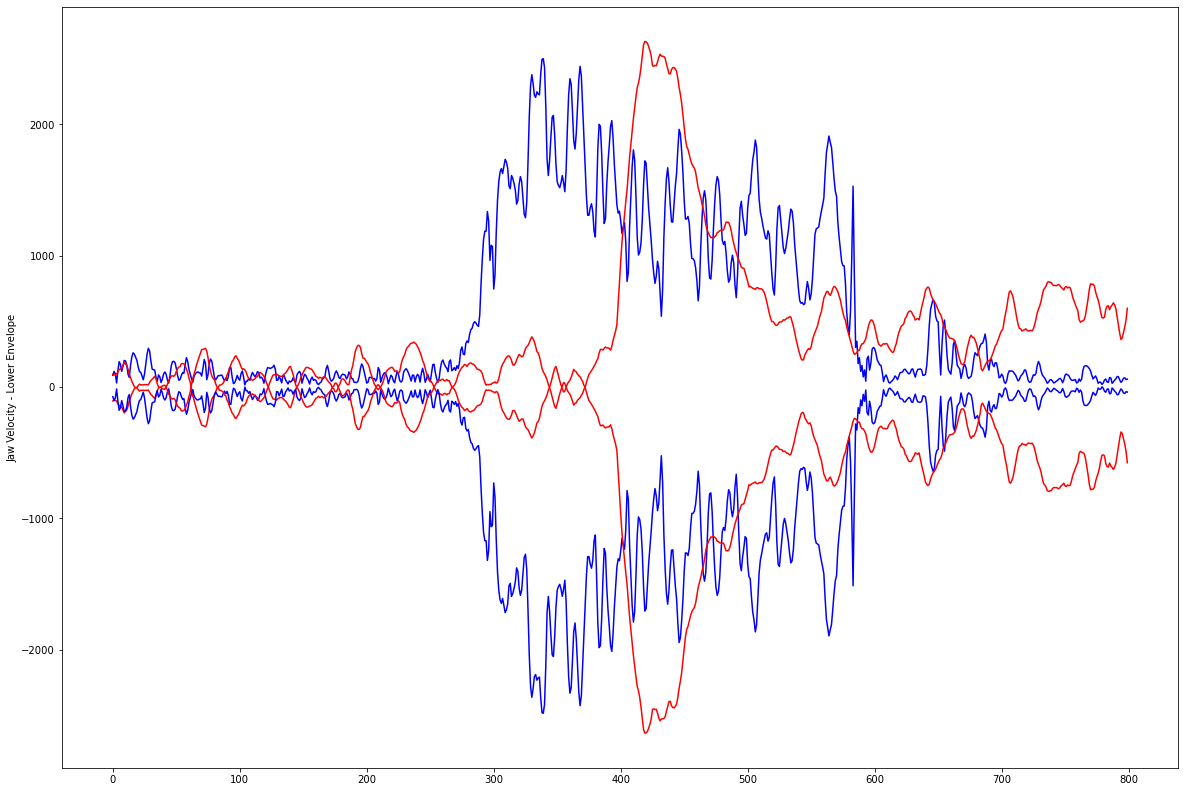

In [144]:

trix = 20 # not actually trial because split arbitrarily in time
ix = np.arange(trix*800-800,trix*800)

fig, axs = plt.subplots(1, 1,figsize=(20,14))
feat = 0
axs.plot(y_kf_valid[ix,feat]+y_kf_train_mean[feat],'b')
axs.plot(y_valid_predicted_kf[ix,feat]+y_kf_train_mean[feat],'r')
axs.set_ylabel('Jaw Velocity - Upper Envelope')



feat = 1
axs.plot(y_kf_valid[ix,feat]+y_kf_train_mean[feat],'b')
axs.plot(y_valid_predicted_kf[ix,feat]+y_kf_train_mean[feat],'r')
axs.set_ylabel('Jaw Velocity - Lower Envelope')


plt.show()



In [125]:
a = y_kf_full.reshape((800,245,2))
b = y.reshape((800,245,2))

print(a.shape)
print(b.shape)

(800, 245, 2)
(800, 245, 2)


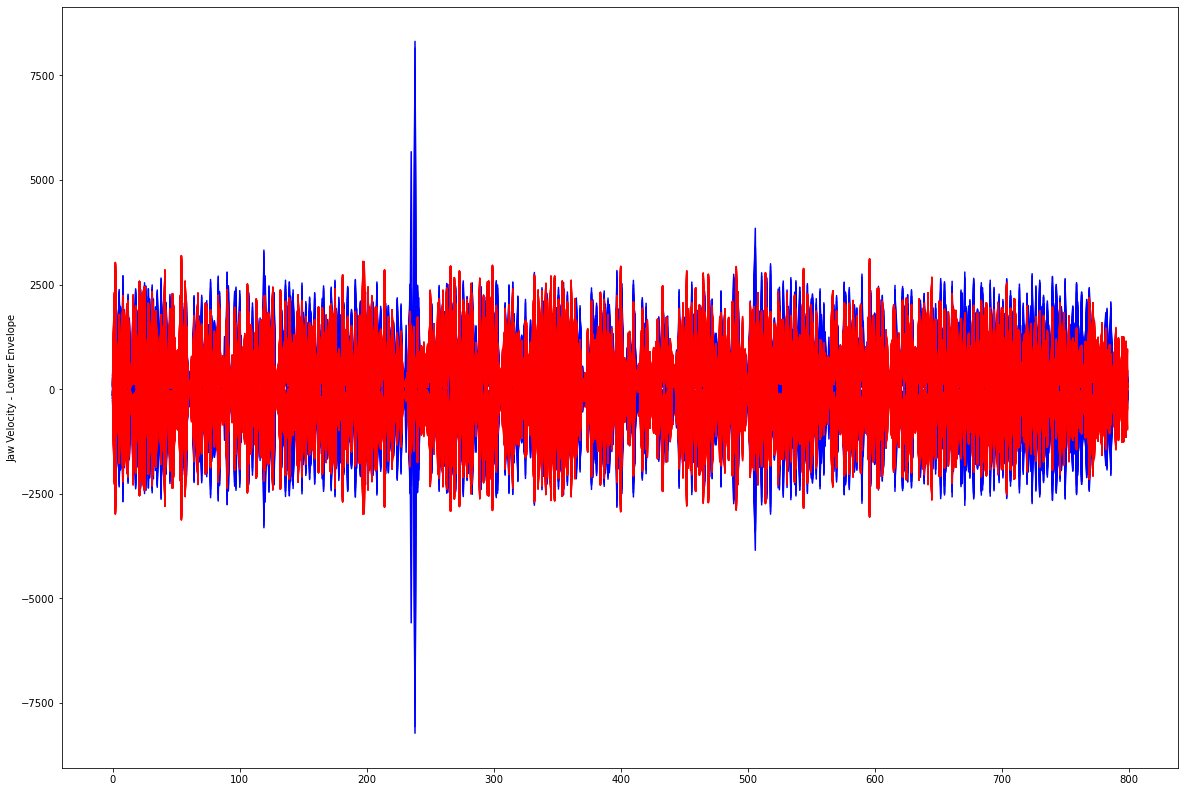

In [127]:
fig, axs = plt.subplots(1, 1,figsize=(20,14))
feat = 0
axs.plot(a[:,:,feat]+y_kf_train_mean[feat],'b')
axs.plot(b[:,:,feat]+y_kf_train_mean[feat],'r')
axs.set_ylabel('Jaw Velocity - Upper Envelope')



feat = 1
axs.plot(a[:,:,feat]+y_kf_train_mean[feat],'b')
axs.plot(b[:,:,feat]+y_kf_train_mean[feat],'r')
axs.set_ylabel('Jaw Velocity - Lower Envelope')


plt.show()


In [137]:
trix = 2
ix = np.arange(trix*800-800,trix*800)

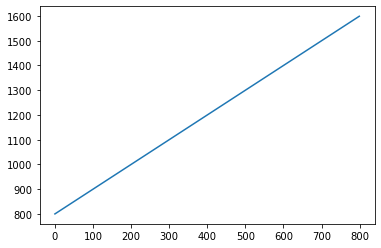

In [139]:
plt.plot(ix)